### Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
#from tensorflow.keras import mixed_precision
#from tensorflow.keras.optimizers import AdamW
from tensorflow_addons.optimizers import AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation 
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import datetime


/Users/akhidre/pubgit/.My_HumanML3D/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/akhidre/pubgit/.My_HumanML3D/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

### Config

In [22]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
from_scratch=False # True: start fresh, False: resume from checkpoint

# Model paths
SAVE_Full_MODEL_PATH = f"/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_2_head_{time_stamp}.keras" # saving full model checkpoint if from scratch=True

LOAD_MODEL_PATH = "/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_rnn_2heads.keras"  # path to load model checkpoint from if from_scratch=False

# TensorBoard directory

log_dir = f"/Users/akhidre/pubgit/CS230_T2motion/fit/{time_stamp}/"

#define data destination
TRAIN_NPZ = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz"
TEST_NPZ  = "/Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz"
NORM_STATS = "motion_norm_stats.npz"   # if exists, used; otherwise computed from train npz

MOTION_LEN = 200         # fixed length for MLP outputs (frames)
NUM_JOINTS = 22
COORDS = 3
OUTPUT_DIM = MOTION_LEN * NUM_JOINTS * COORDS

MAX_TRAIN_SAMPLES =0    # 0 = use all; otherwise use first N pairs
MAX_TEST_SAMPLES = 0   # 0 = use all; otherwise use first N pairs

USE_NORMALIZATION = True  #normalize data to zero mean and unity variance

# Training Monitoring and Callbacks
USE_GPU = False
USE_LR_SCHEDULER = False
USE_EARLY_STOPPING = True
USE_LR_LOGGER = False # only if you added the logger

# Training hyperparams
D_TIME = 32   # Dimension of learnable time embeddings (e.g. 16/32/64)

BATCH_SIZE = 1024
EPOCHS = 1
LEARNING_RATE = 1e-4
HIDDEN_DIMS = [256,256]  # list: number of neurons per hidden Dense layer

# Loss options
USE_VELOCITY_LOSS = True
LAMBDA_VEL = 1
LAMBDA_ROOT = 1.0  # weight for root-velocity loss vs pose loss (tune if needed)

WEIGHT_DECAY = 1e-4

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Utilities Functions

In [14]:
def load_npz_pairs(npz_path, max_samples=0):
    data = np.load(npz_path, allow_pickle=True)
    z_texts = data["z_texts"]   # shape (N, 384)
    motions = data["motions"]   # dtype=object, each entry (T, J, 3)
    motion_ids = data["motion_ids"] if "motion_ids" in data.files else None

    if max_samples and max_samples > 0:
        z_texts = z_texts[:max_samples]
        motions = motions[:max_samples]
        if motion_ids is not None:
            motion_ids = motion_ids[:max_samples]

    return z_texts, motions, motion_ids

def filter_valid_motions(z_list, motions_list, ids_list=None,
                         num_joints=22, coords=3):
    """
    Filters out invalid motion sequences that do not match (T, num_joints, coords).

    Returns:
        valid_z_list, valid_motions_list, valid_ids_list (or None if no ids)
    """
    valid_z = []
    valid_motions = []
    valid_ids = [] if ids_list is not None else None

    for idx, (z, m) in enumerate(zip(z_list, motions_list)):
        arr = np.array(m)

        # Check dimensionality
        if arr.ndim != 3:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (not 3D)")
            continue

        # Check joint and coordinate dimensions
        if arr.shape[1] != num_joints or arr.shape[2] != coords:
            print(f"[Filter] Skipping sample at index={idx}, shape={arr.shape} (bad joint dims)")
            continue

        # Keep sample
        valid_z.append(z)
        valid_motions.append(arr)

        if ids_list is not None:
            valid_ids.append(ids_list[idx])

    if ids_list is not None:
        return np.array(valid_z, dtype=np.float32), valid_motions, valid_ids
    else:
        return np.array(valid_z, dtype=np.float32), valid_motions, None

def pad_or_truncate_motion(motion, target_len=MOTION_LEN):
    """
    motion: (T, J, 3) -> returns (target_len, J, 3)
    """
    T, J, C = motion.shape
    motion = motion.astype(np.float32)
    if T == target_len:
        return motion
    if T > target_len:
        return motion[:target_len]
    # T < target_len: pad by repeating last frame
    pad_len = target_len - T
    last_frame = motion[-1][None, :, :]  # (1, J, 3)
    pad = np.repeat(last_frame, pad_len, axis=0)
    return np.concatenate([motion, pad], axis=0)


def extract_pose_and_rootvel(motion, target_len=MOTION_LEN):
    """
    motion: (T, NUM_JOINTS, 3) in absolute/world coordinates.
    Returns:
      pose_rel: (T, NUM_JOINTS, 3)  -> root-relative pose
      root_vel: (T, 3)              -> root velocity per frame
    """
    motion_fixed = pad_or_truncate_motion(motion, target_len)  # (T,J,3)

    # global root per frame = joint 0
    root = motion_fixed[:, 0, :]                               # (T,3)
    pose_rel = motion_fixed - motion_fixed[:, 0:1, :]          # (T,J,3)

    # root velocities (Δroot); v[0] = 0
    root_vel = np.zeros_like(root)
    root_vel[1:] = root[1:] - root[:-1]
    return pose_rel, root_vel


def compute_pose_rootvel_stats(motions, target_len=MOTION_LEN, save_path=None):
    """
    Compute mean/std for:
      - root-relative pose (per coord)
      - root velocities (per coord)

    motions: list of (T, J, 3) arrays (TRAIN set)
    Returns:
      pose_mean:     (1,1,1,3)
      pose_std:      (1,1,1,3)
      rootvel_mean:  (1,1,3)
      rootvel_std:   (1,1,3)
    """
    pose_coords = []
    rootvel_coords = []

    for m in motions:
        pose_rel, root_vel = extract_pose_and_rootvel(m, target_len)
        pose_coords.append(pose_rel.reshape(-1, COORDS))    # (T*J,3)
        rootvel_coords.append(root_vel.reshape(-1, COORDS)) # (T,3)

    pose_coords = np.concatenate(pose_coords, axis=0)
    rootvel_coords = np.concatenate(rootvel_coords, axis=0)

    pose_mean = pose_coords.mean(axis=0, keepdims=True)         # (1,3)
    pose_std  = pose_coords.std(axis=0, keepdims=True) + 1e-8
    rootvel_mean = rootvel_coords.mean(axis=0, keepdims=True)   # (1,3)
    rootvel_std  = rootvel_coords.std(axis=0, keepdims=True) + 1e-8

    # reshape for broadcasting
    pose_mean    = pose_mean.reshape(1, 1, 1, 3).astype(np.float32)
    pose_std     = pose_std.reshape(1, 1, 1, 3).astype(np.float32)
    rootvel_mean = rootvel_mean.reshape(1, 1, 3).astype(np.float32)
    rootvel_std  = rootvel_std.reshape(1, 1, 3).astype(np.float32)

    if save_path is not None:
        np.savez(
            save_path,
            pose_mean=pose_mean,
            pose_std=pose_std,
            rootvel_mean=rootvel_mean,
            rootvel_std=rootvel_std,
        )
        print(f"Saved pose/rootvel normalization stats to {save_path}")

    return pose_mean, pose_std, rootvel_mean, rootvel_std


### Load data 

In [15]:
print("Loading train npz:", TRAIN_NPZ)
z_train, motions_train, ids_train = load_npz_pairs(TRAIN_NPZ, max_samples=MAX_TRAIN_SAMPLES)
print("Filtering training motions...")
z_train, motions_train, ids_train = filter_valid_motions(z_train, motions_train, ids_train)
print("Final train samples:", len(z_train))

print("Loading test npz:", TEST_NPZ)
z_test, motions_test, ids_test = load_npz_pairs(TEST_NPZ, max_samples=MAX_TEST_SAMPLES)

print("Filtering test motions...")
z_test, motions_test, ids_test = filter_valid_motions(z_test, motions_test, ids_test)
print("Final test samples:", len(z_test))


print("Train captions:", z_train.shape)
print("Train motions count:", len(motions_train))
print("Train ids_count:", len(ids_train))
print("Test captions:", z_test.shape)
print("Test motions count:", len(motions_test))
print("Test ids_count:", len(ids_test))

Loading train npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion.npz
Filtering training motions...
[Filter] Skipping sample at index=2384, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2385, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2386, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14019, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14020, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14021, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37332, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37333, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37334, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48967, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48968, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48969, shape=(22, 3) (not 3D)
Final train samples: 69884
Loading test npz: /Users/akhidre/pubgit/HumanML3D/HumanML3D/paired_text_motion_val.npz
Filteri

### Compute data statistics

In [16]:
if os.path.exists(NORM_STATS):
    stats = np.load(NORM_STATS)
    pose_mean     = stats["pose_mean"]
    pose_std      = stats["pose_std"]
    rootvel_mean  = stats["rootvel_mean"]
    rootvel_std   = stats["rootvel_std"]
    print("Loaded normalization stats from", NORM_STATS)
else:
    print("Computing normalization stats (root-relative pose + root velocity)...")
    pose_mean, pose_std, rootvel_mean, rootvel_std = compute_pose_rootvel_stats(
        motions_train,
        target_len=MOTION_LEN,
        save_path=None
    )

print("pose_mean:", pose_mean, "pose_std:", pose_std)
print("rootvel_mean:", rootvel_mean, "rootvel_std:", rootvel_std)


Computing normalization stats (root-relative pose + root velocity)...
pose_mean: [[[[-0.00023493 -0.02042538  0.01167196]]]] pose_std: [[[[0.1076361  0.23476106 0.1065274 ]]]]
rootvel_mean: [[[ 3.9163851e-06 -8.9967598e-06  2.7644455e-03]]] rootvel_std: [[[0.01206515 0.0096471  0.01815101]]]


### Prepare dataset

In [17]:
def prepare_xy_multi(z_list,
                     motions_objectlist,
                     pose_mean, pose_std,
                     rootvel_mean, rootvel_std,
                     motion_len=MOTION_LEN,use_normalization=USE_NORMALIZATION):
    """
    Returns:
      X:       (N, 384)
      Y_pose:  (N, T, J, 3)   normalized root-relative pose
      Y_root:  (N, T, 3)      normalized root velocities
    """
    N = len(z_list)
    X = np.array(z_list, dtype=np.float32)  # (N, 384)

    Y_pose = np.zeros((N, motion_len, NUM_JOINTS, COORDS), dtype=np.float32)
    Y_root = np.zeros((N, motion_len, COORDS), dtype=np.float32)

    for i, m in enumerate(motions_objectlist):
        pose_rel, root_vel = extract_pose_and_rootvel(m, target_len=motion_len)

        pose_norm    = (pose_rel - pose_mean) / pose_std
        rootvel_norm = (root_vel - rootvel_mean) / rootvel_std
        if use_normalization:
            Y_pose[i] = pose_norm
            Y_root[i] = rootvel_norm
        else:
            Y_pose[i] = pose_rel
            Y_root[i] = root_vel

    return X, Y_pose, Y_root

print("Preparing training tensors...")
X_train, Y_pose_train, Y_root_train = prepare_xy_multi(
    z_train, motions_train,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)

print("Preparing test tensors...")
X_test, Y_pose_test, Y_root_test = prepare_xy_multi(
    z_test, motions_test,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)


print("Shapes:")
print("  X_train:", X_train.shape)
print("  Y_pose_train:", Y_pose_train.shape)
print("  Y_root_train:", Y_root_train.shape)
print("  X_test:", X_test.shape)
print("  Y_pose_test:", Y_pose_test.shape)
print("  Y_root_test:", Y_root_test.shape)


Preparing training tensors...
Preparing test tensors...
Shapes:
  X_train: (69884, 384)
  Y_pose_train: (69884, 200, 22, 3)
  Y_root_train: (69884, 200, 3)
  X_test: (4362, 384)
  Y_pose_test: (4362, 200, 22, 3)
  Y_root_test: (4362, 200, 3)


### Model

In [18]:
tf.keras.backend.clear_session()  # Clear any existing session

# Optional mixed precision on GPU
if USE_GPU:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())

# ---------------------------
# Inputs: sentence embedding z_text (384-d)
# ---------------------------
inputs = tf.keras.Input(
    shape=(X_train.shape[1],),  # 384 for all-MiniLM
    dtype=tf.float32,
    name="z_text"
)

CAP_DIM = X_train.shape[1]      # typically 384

# 1) Repeat text embedding across time -> [B, T, CAP_DIM]
z_seq = tf.keras.layers.RepeatVector(MOTION_LEN, name="repeat_text")(inputs)

# 2) Learnable time embedding indices [0..T-1]
def make_time_indices(z):
    batch_size = tf.shape(z)[0]
    time_range = tf.range(MOTION_LEN, dtype=tf.int32)  # [T]
    time_range = tf.expand_dims(time_range, axis=0)    # [1, T]
    time_indices = tf.tile(time_range, [batch_size, 1])  # [B, T]
    return time_indices

time_indices = tf.keras.layers.Lambda(
    make_time_indices,
    name="time_indices"
)(inputs)  # [B, T]

time_embedding_layer = tf.keras.layers.Embedding(
    input_dim=MOTION_LEN,   # one embedding per frame index
    output_dim=D_TIME,
    name="time_embedding"
)

time_seq = time_embedding_layer(time_indices)  # [B, T, D_TIME]

# 3) Concatenate text + time -> [B, T, CAP_DIM + D_TIME]
decoder_input = tf.keras.layers.Concatenate(
    axis=-1,
    name="concat_text_time"
)([z_seq, time_seq])

# 4) Stacked GRU decoder over time using HIDDEN_DIMS

# Learn initial hidden state from caption only
init_state = tf.keras.layers.Dense(
    HIDDEN_DIMS[0],           # same size as first GRU layer
    activation="tanh",
    name="init_state_from_caption"
)(inputs)                     # inputs is z_text: (B, CAP_DIM)

# First GRU layer uses learned initial_state
x = tf.keras.layers.GRU(
    HIDDEN_DIMS[0],
    return_sequences=True,
    name="gru_layer_1"
)(decoder_input, initial_state=init_state)

# Additional GRU layers (if any) stack on top, default zero init is fine
for i, h in enumerate(HIDDEN_DIMS[1:], start=2):
    x = tf.keras.layers.GRU(
        h,
        return_sequences=True,
        name=f"gru_layer_{i}"
    )(x)


# 5) Two heads:
#    - pose_out:    (B, T, 22, 3)   root-relative pose
#    - rootvel_out: (B, T, 3)       root velocities

# Pose head
pose_out_flat = tf.keras.layers.Dense(
    NUM_JOINTS * COORDS,
    name="pose_frame_dense"
)(x)                   # (B, T, 66)

pose_out = tf.keras.layers.Reshape(
    (MOTION_LEN, NUM_JOINTS, COORDS),
    name="pose_out"
)(pose_out_flat)       # (B, T, 22, 3)

# Root-velocity head
rootvel_out = tf.keras.layers.Dense(
    COORDS,
    name="rootvel_out"
)(x)                   # (B, T, 3)

model = tf.keras.Model(
    inputs=inputs,
    outputs=[pose_out, rootvel_out],
    name="GRU_TimeCond_Motion_Decoder"
)

model.summary()

# ---------------------------
# Losses
# ---------------------------
def pose_loss_with_vel(y_true, y_pred):
    """
    y_*: (B, T, J, 3)
    MSE on pose + optional velocity loss on pose.
    """
    pos_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    if USE_VELOCITY_LOSS:
        vel_true = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
        vel_pred = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
        vel_loss = tf.reduce_mean(tf.square(vel_true - vel_pred))
        return pos_loss + LAMBDA_VEL * vel_loss
    else:
        return pos_loss


optimizer = AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss=[pose_loss_with_vel, "mse"],      # [pose_out, rootvel_out]
    loss_weights=[1.0, LAMBDA_ROOT]
)



Model: "GRU_TimeCond_Motion_Decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_text (InputLayer)         [(None, 384)]                0         []                            
                                                                                                  
 time_indices (Lambda)       (None, 200)                  0         ['z_text[0][0]']              
                                                                                                  
 repeat_text (RepeatVector)  (None, 200, 384)             0         ['z_text[0][0]']              
                                                                                                  
 time_embedding (Embedding)  (None, 200, 32)              6400      ['time_indices[0][0]']        
                                                                        

### Training callbacks and monitors 

In [19]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # enables gradients & weights monitoring
    write_graph=False
)

# Reduce LR on Plateau
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Early stopping
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Save best weights only
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=SAVE_Full_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
class LRTensorBoard(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        with self.file_writer.as_default():
            tf.summary.scalar("learning_rate", lr, step=epoch)

lr_logger = LRTensorBoard(log_dir=log_dir)





callbacks_list = [tensorboard_cb, checkpoint_cb]

if USE_LR_SCHEDULER:
    callbacks_list.append(reduceLR_cb)

if USE_EARLY_STOPPING:
    callbacks_list.append(earlystop_cb)

# Optional: add LR logger if you use it
if USE_LR_LOGGER:
    callbacks_list.append(lr_logger)

### Training

Loading model from: /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_rnn_2heads.keras
69/69 [==============================] - ETA: 0s - loss: 1.7413 - pose_out_loss: 0.7905 - rootvel_out_loss: 0.9509
Epoch 1: val_loss improved from inf to 1.72979, saving model to /Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_RNN_2_head_20251127-122425.keras
69/69 [==============================] - 252s 4s/step - loss: 1.7413 - pose_out_loss: 0.7905 - rootvel_out_loss: 0.9509 - val_loss: 1.7298 - val_pose_out_loss: 0.8137 - val_rootvel_out_loss: 0.9161


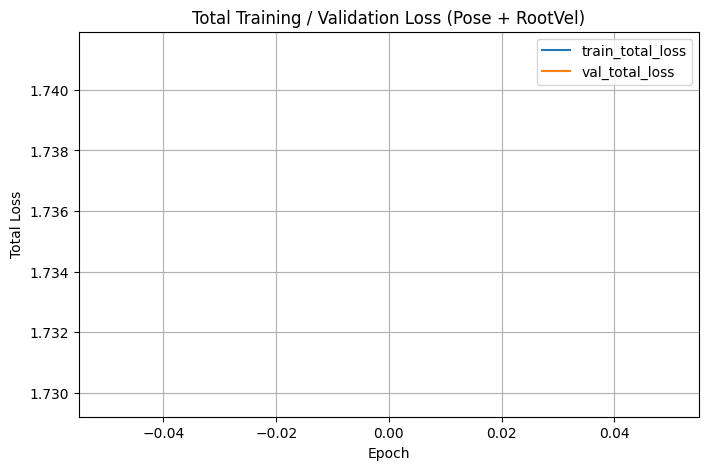

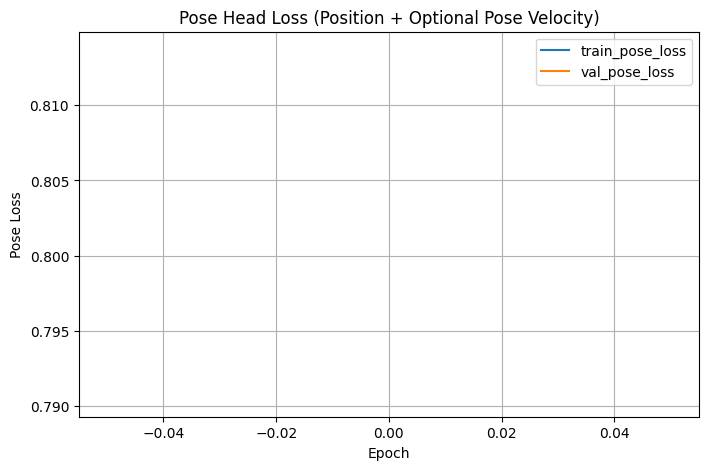

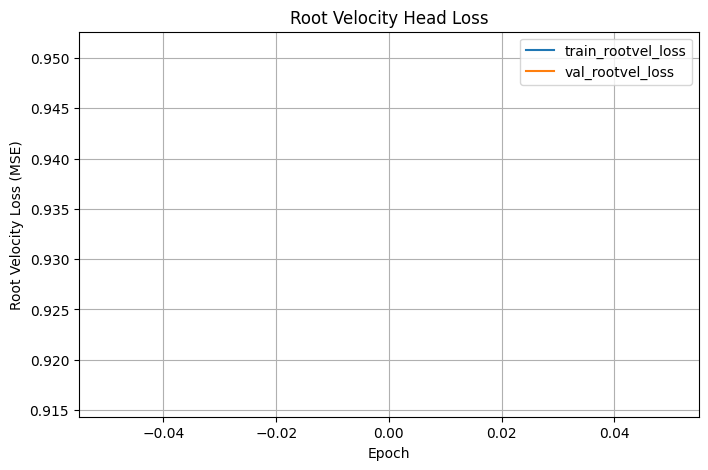

In [25]:
if not from_scratch:
    if os.path.exists(LOAD_MODEL_PATH):
        print(f"Loading model from: {LOAD_MODEL_PATH}")
        
        model = tf.keras.models.load_model(LOAD_MODEL_PATH,
            custom_objects={'pose_loss_with_vel': pose_loss_with_vel,},
            safe_mode=False
        )
    else:
         raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")
else:
    print("Training from scratch")

tf.config.run_functions_eagerly(False)  # for performance

history = model.fit(
    X_train,
    [Y_pose_train, Y_root_train],
    validation_data=(X_test, [Y_pose_test, Y_root_test]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)

# ----------------------------
# 1) Combined Loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_total_loss')
plt.plot(history.history['val_loss'], label='val_total_loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training / Validation Loss (Pose + RootVel)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 2) Pose-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['pose_out_loss'], label='train_pose_loss')
plt.plot(history.history['val_pose_out_loss'], label='val_pose_loss')
plt.xlabel('Epoch')
plt.ylabel('Pose Loss')
plt.title('Pose Head Loss (Position + Optional Pose Velocity)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 3) Root-velocity-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['rootvel_out_loss'], label='train_rootvel_loss')
plt.plot(history.history['val_rootvel_out_loss'], label='val_rootvel_loss')
plt.xlabel('Epoch')
plt.ylabel('Root Velocity Loss (MSE)')
plt.title('Root Velocity Head Loss')
plt.legend()
plt.grid(True)
plt.show()


### Choosing Model for Inferance

In [26]:
if from_scratch:
    print("Using model already in memory (just trained).")
else:
    print(f"\nLoading model from file:\n{LOAD_MODEL_PATH}\n")

    if not os.path.exists(LOAD_MODEL_PATH):
        raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")

    model = tf.keras.models.load_model(LOAD_MODEL_PATH,
        custom_objects={
            'pose_loss_with_vel': pose_loss_with_vel,
        },
        safe_mode=False
    )

    print("Model loaded successfully for inference.")


Loading model from file:
/Users/akhidre/pubgit/CS230_T2motion/models/full_checkpoint_rnn_2heads.keras

Model loaded successfully for inference.


### Run Inference Example

In [30]:
sample_idx = 0   # pick any index from test set

motion_id = ids_test[sample_idx]
print("Test motion ID:", motion_id)

# Input embedding
z = X_test[sample_idx:sample_idx+1]   # (1, CAP_DIM)

# Forward pass through model -> two heads
pred_pose_out, pred_rootvel_out = model.predict(z)   # (1,T,J,3), (1,T,3)

# Remove batch dimension
pred_pose_out = pred_pose_out[0]       # (T,J,3)
pred_rootvel_out = pred_rootvel_out[0] # (T,3)

if USE_NORMALIZATION:
    # denormalize root-relative pose
    pred_pose_rel = (
        pred_pose_out * pose_std[0, 0, 0, :] + pose_mean[0, 0, 0, :]
    )  # (T,J,3)

    # denormalize root velocities
    pred_root_vel = (
        pred_rootvel_out * rootvel_std[0, 0, :] + rootvel_mean[0, 0, :]
    )  # (T,3)

else:
    # model already trained on raw values
    pred_pose_rel = pred_pose_out       # (T,J,3) root-relative, unnormalized
    pred_root_vel = pred_rootvel_out    # (T,3)   root velocity, unnormalized

# calculate root trajectory from root velocities

root_pred = np.zeros_like(pred_root_vel, dtype=np.float32)  # (T,3)
for t in range(1, MOTION_LEN):
    root_pred[t] = root_pred[t - 1] + pred_root_vel[t]

root_pred_expanded = root_pred[:, None, :]                   # (T,1,3)
pred_world = pred_pose_rel + root_pred_expanded              # (T,22,3)

print("Predicted motion (world coords) shape:", pred_world.shape)

# GT motion (padded) for comparison 
gt_motion_fixed = pad_or_truncate_motion(motions_test[sample_idx], MOTION_LEN)
print("GT motion shape:", gt_motion_fixed.shape)


Test motion ID: 012698
1/1 [==============================] - 0s 31ms/step
Predicted motion (world coords) shape: (200, 22, 3)
GT motion shape: (200, 22, 3)


### Animation of Generated Motion

In [31]:
# SMPL 22-joint skeleton edges
edges = [
    (0, 1), (1, 4), (4, 7), (7, 10),
    (0, 2), (2, 5), (5, 8), (8, 11),
    (0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
    (9, 13), (13, 16), (16, 18), (18, 20),
    (9, 14), (14, 17), (17, 19), (19, 21),
]

def save_motion_animation(motion, label, motion_id, base_dir):
    """
    motion: (T, 22, 3)
    label:  'generated' or 'gt'
    """
    pose = copy.deepcopy(motion)  # (T,22,3)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # FIXED AXIS LIMITS 
    ax.set(xlim3d=(-1, 3), xlabel='X')
    ax.set(ylim3d=(-1, 1), ylabel='Y')
    ax.set(zlim3d=(-1, 1), zlabel='Z')


    # Auto axis limits from motion
    #coords = pose.reshape(-1, 3)
    #x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    #y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
    #z_min, z_max = coords[:, 2].min(), coords[:, 2].max()
    #margin = 0.1

    #ax.set_xlim(x_min - margin, x_max + margin)
    #ax.set_ylim(y_min - margin, y_max + margin)
    #ax.set_zlim(z_min - margin, z_max + margin)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Create one line per edge
    lines = [ax.plot([], [], [])[0] for _ in edges]

    def update_lines(frame_num, pose, lines):
        frame = pose[frame_num]
        for n, (i, j) in enumerate(edges):
            x = [frame[i, 0], frame[j, 0]]
            y = [frame[i, 1], frame[j, 1]]
            z = [frame[i, 2], frame[j, 2]]
            # Keep your preferred orientation:
            lines[n].set_data_3d([z, x, y])
        return lines

    ani = FuncAnimation(
        fig,
        update_lines,
        frames=pose.shape[0],
        fargs=(pose, lines),
        interval=100
    )

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{base_dir}/{label}_{motion_id}_{timestamp}.mp4"
    ani.save(save_path, writer='ffmpeg', fps=30)
    print(f"Saved {label} animation to:", save_path)
    plt.close(fig)


# save directory
anim_dir = "/Users/akhidre/pubgit/CS230_T2Motion/animations"

# Save predicted motion
save_motion_animation(pred_world, "generated_RNN_2heads", motion_id, anim_dir)

# Save GT motion
save_motion_animation(gt_motion_fixed, "gt_fixed", motion_id, anim_dir)

Saved generated_RNN_2heads animation to: /Users/akhidre/pubgit/CS230_T2Motion/animations/generated_RNN_2heads_012698_20251127_132741.mp4
Saved gt_fixed animation to: /Users/akhidre/pubgit/CS230_T2Motion/animations/gt_fixed_012698_20251127_132748.mp4


### Troubleshoot/Debug

In [23]:
# Analyze predicted vs ground-truth motion for sample_idx 
# 1) Rebuild the ground-truth motion for the same sample_idx
gt_motion_raw = motions_test[sample_idx]  # this is an object array (T, 22, 3)
gt_motion_fixed = pad_or_truncate_motion(gt_motion_raw, target_len=MOTION_LEN)

if USE_NORMALIZATION:
    # If you ever turn normalization back on, you need to denormalize both
    gt_motion_real = denormalize_motion(gt_motion_fixed, mean, std)
    pred_motion_real = denormalize_motion(pred_3d, mean, std)
else:
    gt_motion_real = gt_motion_fixed.astype(np.float32)
    pred_motion_real = pred_real.astype(np.float32)  # already float32

print("GT motion shape:", gt_motion_real.shape)
print("Pred motion shape:", pred_motion_real.shape)


# 2) Simple per-frame stats to see "scale" and position
def motion_frame_stats(name, motion, frame_idx):
    f = motion[frame_idx]                 # [22, 3]
    min_xyz = f.min(axis=0)
    max_xyz = f.max(axis=0)
    center = f.mean(axis=0)
    # approximate skeleton scale = max distance from the frame center
    scale = np.linalg.norm(f - center, axis=1).max()
    print(f"{name} frame {frame_idx:3d} | "
          f"center {center} | min {min_xyz} | max {max_xyz} | scale {scale:.3f}")

for fi in [0, 1, 5, 10, 50, 100, 199]:
    print("==== frame", fi, "====")
    motion_frame_stats("GT  ", gt_motion_real, fi)
    motion_frame_stats("Pred", pred_motion_real, fi)
    print()
    

# 3) Track how skeleton scale changes over time
def skeleton_scale_over_time(motion):
    # assume joint 0 is root
    root = motion[:, 0, :]                             # [T, 3]
    dists = np.linalg.norm(motion - root[:, None, :], axis=2)  # [T, 22]
    return dists.max(axis=1)                           # [T]

gt_scale = skeleton_scale_over_time(gt_motion_real)
pred_scale = skeleton_scale_over_time(pred_motion_real)

print("First 10 GT scales:   ", gt_scale[:10])
print("First 10 Pred scales: ", pred_scale[:10])
print("Mean GT scale:", gt_scale.mean(), "Mean Pred scale:", pred_scale.mean())




GT motion shape: (200, 22, 3)
Pred motion shape: (200, 22, 3)
==== frame 0 ====
GT   frame   0 | center [-0.02864403  0.96302295  0.02325513] | min [-0.44450423  0.02759657 -0.21121013] | max [0.21953316 1.5654216  0.27112737] | scale 0.958
Pred frame   0 | center [0.00153125 0.19702187 0.01724212] | min [-0.05245192  0.00887568  0.00560129] | max [0.0564133 0.3203984 0.031524 ] | scale 0.192

==== frame 1 ====
GT   frame   1 | center [-0.03720071  0.95801127  0.03821034] | min [-0.45528355  0.02489816 -0.20703632] | max [0.20616621 1.5639188  0.26679406] | scale 0.953
Pred frame   1 | center [0.00263812 0.43550768 0.03544001] | min [-0.1042376   0.02060861  0.01222342] | max [0.11616597 0.7143726  0.06515045] | scale 0.421

==== frame 5 ====
GT   frame   5 | center [-0.05281306  0.92984957  0.11754942] | min [-0.3982659   0.02329702 -0.04673944] | max [0.1719622 1.5448701 0.2994337] | scale 0.916
Pred frame   5 | center [0.00562967 0.87676024 0.07665091] | min [-0.20799063  0.03914583